In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 99% !important;}</style>"))

In [3]:
import numpy   as np
import scipy   as sp
import pandas  as pd
import seaborn as sns
import matplotlib
import kabuki
from matplotlib import pyplot as plt
import ipyparallel
from ipyparallel import parallel
import hddm
import os

%matplotlib inline
np.set_printoptions(suppress = True)

In [4]:
mac         = False
workstation = True
if workstation:
    os.chdir("/home/sammirc/Experiments/Nick/AttentionSaccade") #workstation directory
elif mac:
    os.chdir("/Users/user/Desktop/Experiments/Nick/AttentionSaccade") #laptop directory


sublist = [1,2,3,4,5,6,7,8,9]

datafname = os.path.join(os.getcwd(), 'AttentionSaccade_BehaviouralData_All.csv')
data = pd.read_csv(datafname, sep = ',', index_col = False) #read in collated data
data = data.drop(data.columns[0], axis = 1) #drop unnamed, random column that has appeared in the data
attention = data.loc[data['task']==1]
saccade   = data.loc[data['task']==2]
attention.columns

Index([u'subject', u'session', u'trial', u'task', u'cuecol', u'cueloc',
       u'validity', u'targloc', u'targtilt', u'delay', u'resp', u'time',
       u'corr'],
      dtype='object')

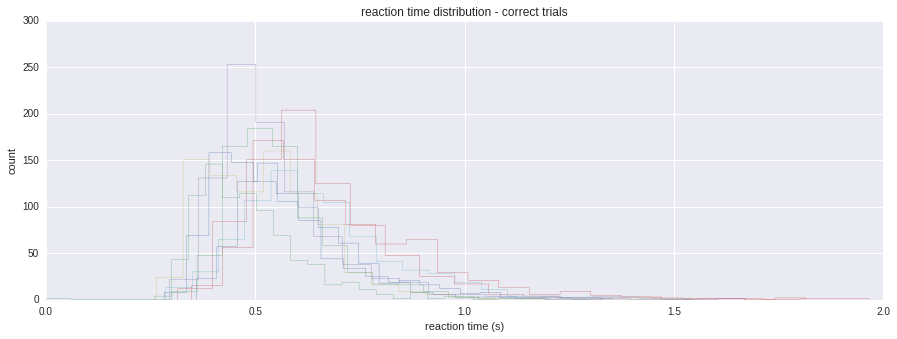

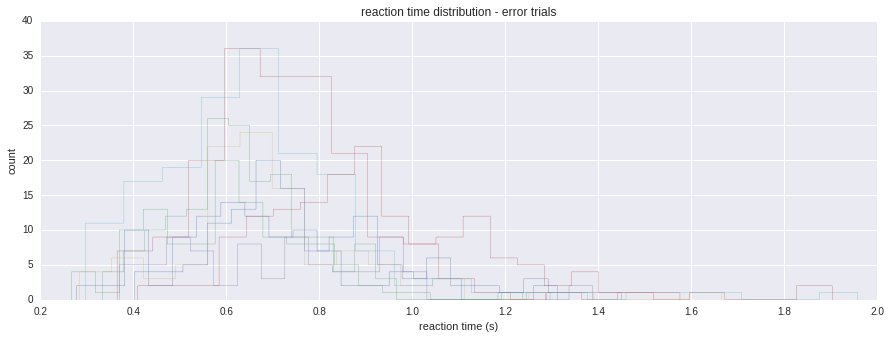

In [5]:
#plot response distribution for correct trials
plt.rcParams['figure.figsize'] = (15,5)
for i, subject in attention.loc[attention['corr']==1].groupby('subject'):
    subject.time.hist(bins = 20, histtype = 'step')
plt.title('reaction time distribution - correct trials')
plt.xlabel('reaction time (s)'); plt.ylabel('count')

# plot response distribution for incorrect trials
plt.figure()
for i, subject in attention.loc[attention['corr']==0].groupby('subject'):
    subject.time.hist(bins=20, histtype = 'step')
plt.title('reaction time distribution - error trials')
plt.xlabel('reaction time (s)'); plt.ylabel('count')

In [6]:
attention = attention[['subject', 'time', 'corr', 'validity']] #select dataframe down to just these variables
attention = attention.rename(columns={'time':'rt', "corr":'response','subject':'subj_idx'}) #rename for use with hddm package
attention = attention[np.isnan(attention['rt'])==False] #remove trials with no response

attval = attention[attention['validity']==1]
attinv = attention[attention['validity']==0]
#rename coding of validity to string instead of number
attention.loc[attention.validity==1, 'validity'] = 'valid'
attention.loc[attention.validity==0, 'validity'] = 'invalid'

#attention.shape
#attention = attention[attention['rt']<0.05]
#np.where(np.isnan(attention['rt'])) #check for missing data

In [7]:
#drift diffusion model on attention task data
if not os.path.exists(os.path.join(os.getcwd(),'fullDDM_attention.db')):
    model = hddm.HDDM(data= attention, p_outlier=0.05, bias = True, trace_subjs = True,
                 depends_on = {'v':'validity', # a (decision threshold) should be kept fixed across participants, unless a reason to assume it shouldn't be
                               't':'validity', 'z':'validity'}, # 'sv' prone to fit errors (see de Gee et al. eLife 2017) so fit across conditions to maximise fit
                 include = {'sv', 'a', 'v', 't', 'z'})
    model.find_starting_values()
    model.sample(2000, burn=20, dbname = 'fullDDM_attention.db', db = 'pickle')
    model.save('fullDDM_attention')
else:
    model = hddm.load('fullDDM_attention')
    
stats = model.gen_stats()
stats[stats.index.isin(['a', 'v(valid)', 'v(invalid)', 't(valid)', 't(invalid)', 'z(valid)', 'z(invalid)'])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.30164,0.0428112,1.2215,1.27442,1.30047,1.32929,1.39153,0.00119074
v(invalid),1.56899,0.208682,1.15735,1.42682,1.57329,1.70717,1.97407,0.00669192
v(valid),2.42144,0.200121,2.04578,2.29233,2.41925,2.55274,2.83037,0.00599234
t(invalid),0.411153,0.0203804,0.371161,0.398497,0.410973,0.424662,0.451719,0.000489891
t(valid),0.317748,0.020124,0.278698,0.304289,0.317758,0.330873,0.357574,0.000473409
z(invalid),0.481228,0.0160308,0.449907,0.470966,0.481077,0.491553,0.512862,0.000714282
z(valid),0.438006,0.0134251,0.412382,0.428971,0.438172,0.44666,0.46485,0.000567786


In [8]:
# read in/create model where all params except drift rate can vary across validity conditions
if not os.path.exists(os.path.join(os.getcwd(),'DDM_attention_fixDR.db')):
    model_fixDR = hddm.HDDM(data= attention, p_outlier=0.05, bias = True, trace_subjs = True,
                 depends_on = {#'v':'validity', #keep drift rate fixed across conditions to see effect of validity in model fit
                               't':'validity', 'z':'validity'}, # 'sv' prone to fit errors (see de Gee et al. eLife 2017) so fit across conditions to maximise fit
                 include = {'sv'})
    model_fixDR.find_starting_values()
    model_fixDR.sample(2000, burn=20, dbname = 'DDM_attention_fixDR.db', db = 'pickle')
    model_fixDR.save('DDM_attention_fixDR')
else:
    model_fixDR = hddm.load('DDM_attention_fixDR')
    
stats_fixDR = model_fixDR.gen_stats()
stats_fixDR[stats_fixDR.index.isin(['a', 'v', 't(valid)', 't(invalid)', 'z(valid)', 'z(invalid)'])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
v,2.21955,0.159756,1.90441,2.15898,2.23881,2.36088,2.51975,0.03261
t(invalid),0.40892,0.0138945,0.375175,0.399891,0.413311,0.418846,0.431123,0.0028362
t(valid),0.320497,0.0161544,0.289873,0.313177,0.319302,0.327778,0.36294,0.0032975
z(invalid),0.410957,0.0128181,0.384308,0.403857,0.410608,0.416658,0.450565,0.00261647
z(valid),0.449777,0.0100311,0.426238,0.443809,0.451385,0.456096,0.468888,0.00204758


In [9]:
#diffusion model of attention data, all parameters fixed across conditions (not depending on validity)
if not os.path.exists(os.path.join(os.getcwd(), 'DDM_attention_fixed.db')):
    model_fixed = hddm.HDDM(data = attention, p_outlier = 0.05, trace_subjs = True, include = {'a','v','t','z', 'sv'})
    model_fixed.find_starting_values()
    model_fixed.sample(2000, burn = 20, dbname = 'DDM_attention_fixed.db', db='pickle')
    model_fixed.save('DDM_attention_fixed')
else:
    model_fixed = hddm.load('DDM_attention_fixed')

stats_fixed = model_fixed.gen_stats()
stats_fixed[stats_fixed.index.isin(['a', 'v', 't', 'z'])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.33847,0.0477514,1.25008,1.30716,1.33627,1.36745,1.43863,0.0016399
v,2.12256,0.173964,1.77443,2.01895,2.11946,2.22628,2.48777,0.0057681
t,0.320084,0.0175202,0.287142,0.308654,0.319322,0.330771,0.357119,0.000430791
z,0.457207,0.0117909,0.434251,0.449481,0.45676,0.465213,0.480234,0.000535184


In [10]:
print 'full model (fixed DC) : ', model.dic_info
print 'model fixing DC and DR across validity: ', model_fixDR.dic_info
print 'model fixing all parameters across validity: ', model_fixed.dic_info

full model (fixed DC) :  {'deviance': -1306.5296580375921, 'pD': 55.155653894951911, 'DIC': -1251.3740041426402}
model fixing DC and DR across validity:  {'deviance': -1181.6046493704471, 'pD': 44.077490307678545, 'DIC': -1137.5271590627685}
model fixing all parameters across validity:  {'deviance': -100.62815303857609, 'pD': 33.848391539894678, 'DIC': -66.77976149868141}


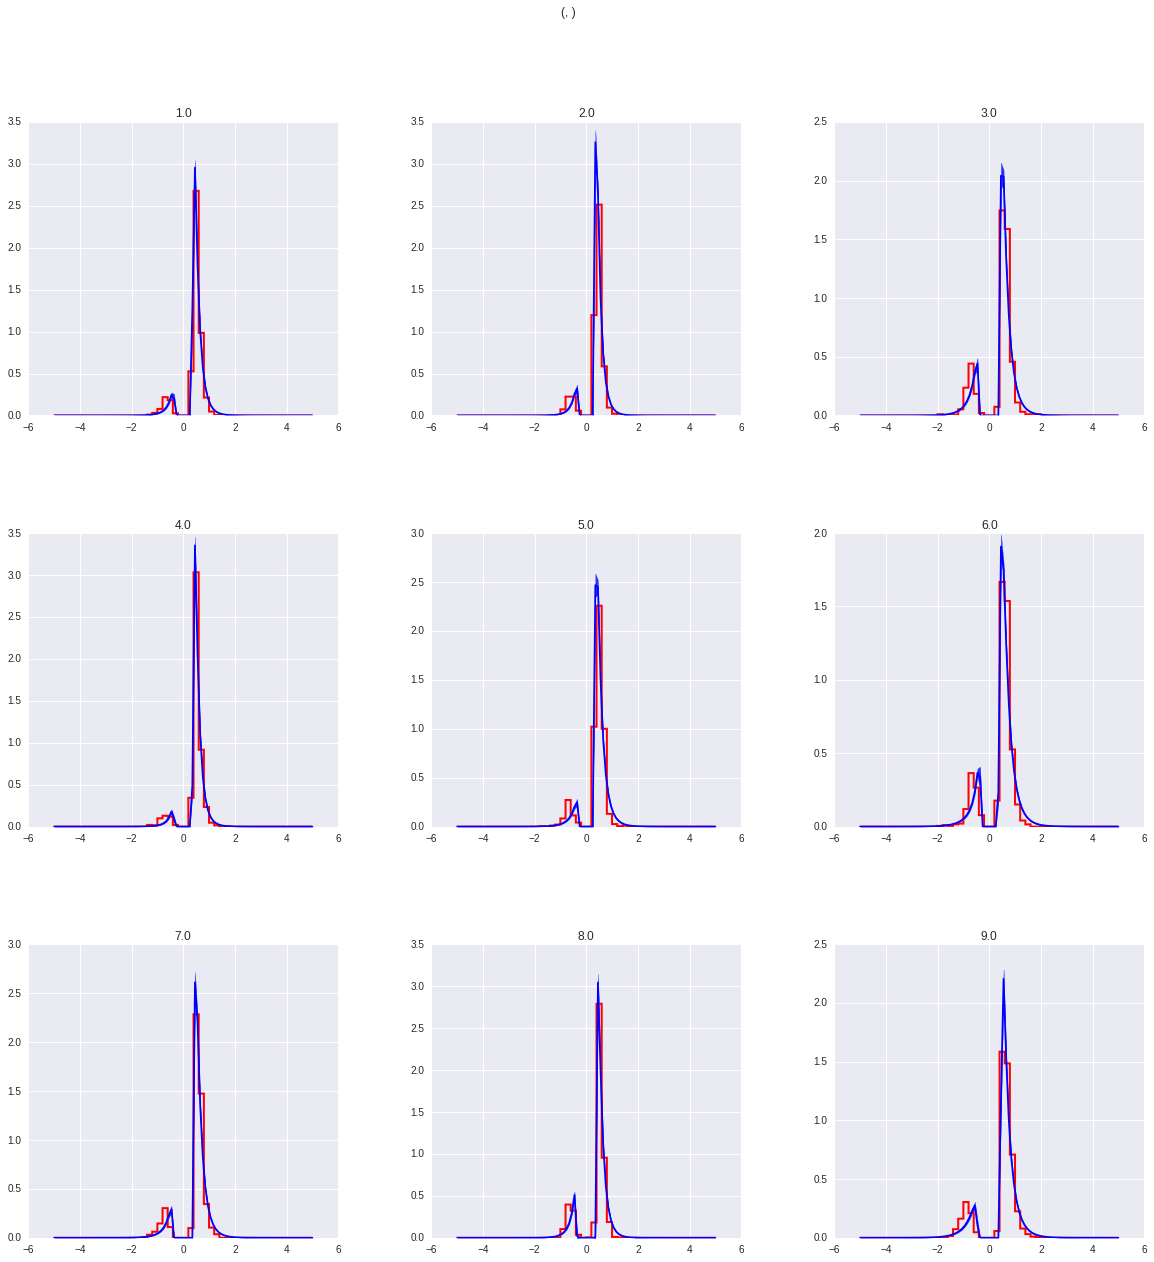

In [12]:
model_fixed.plot_posterior_predictive(figsize=(20,20), samples = 100, bins = 50)

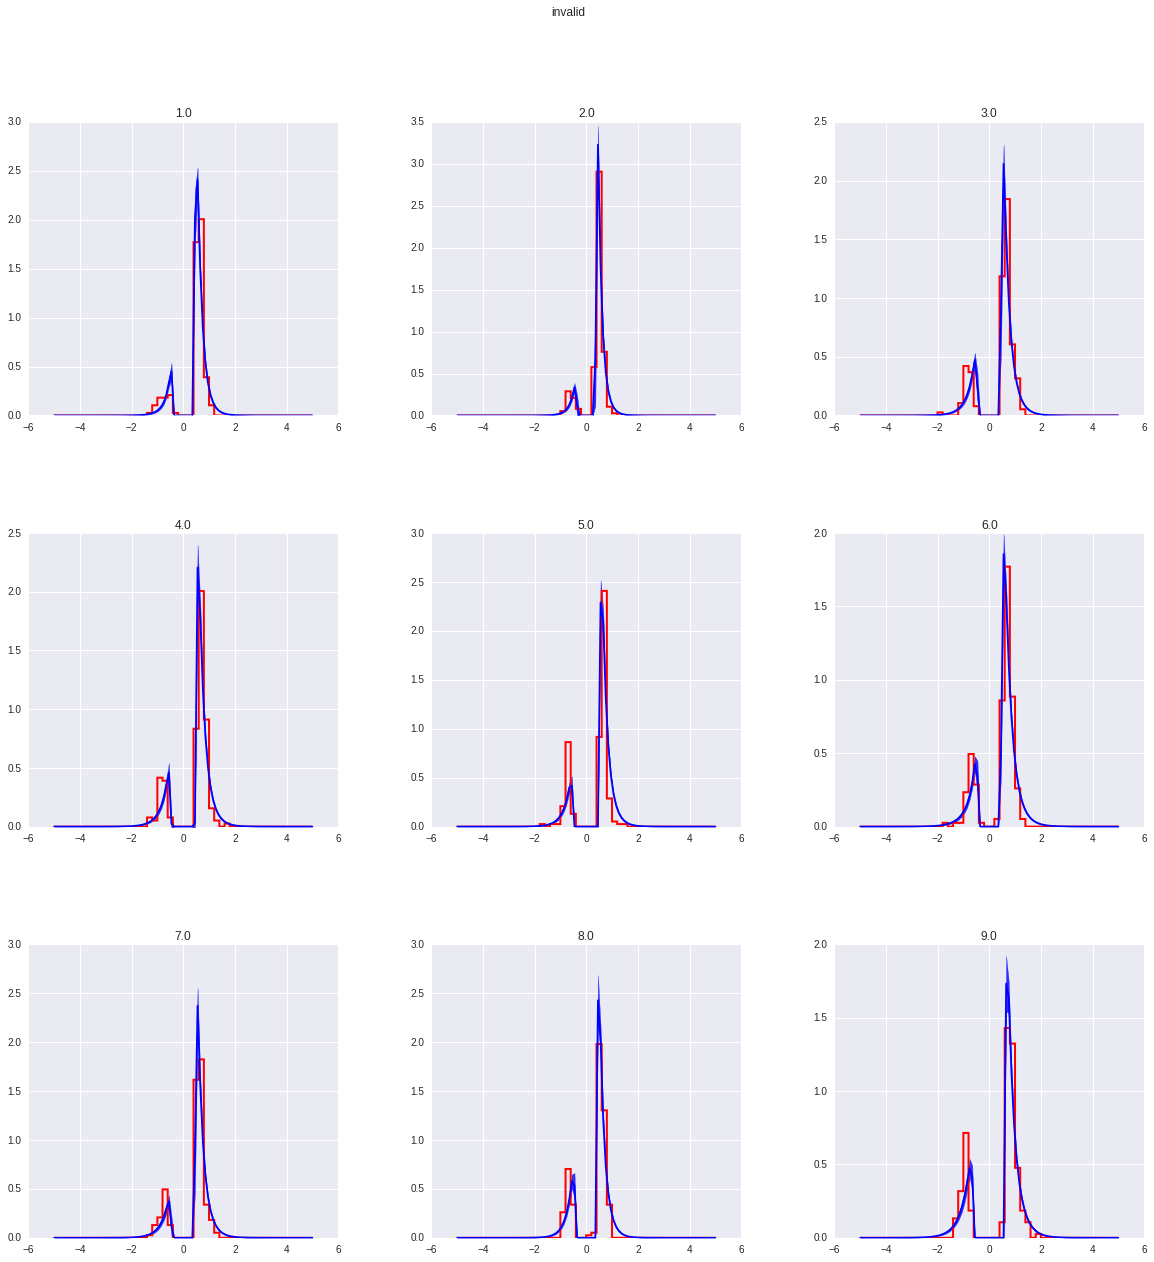

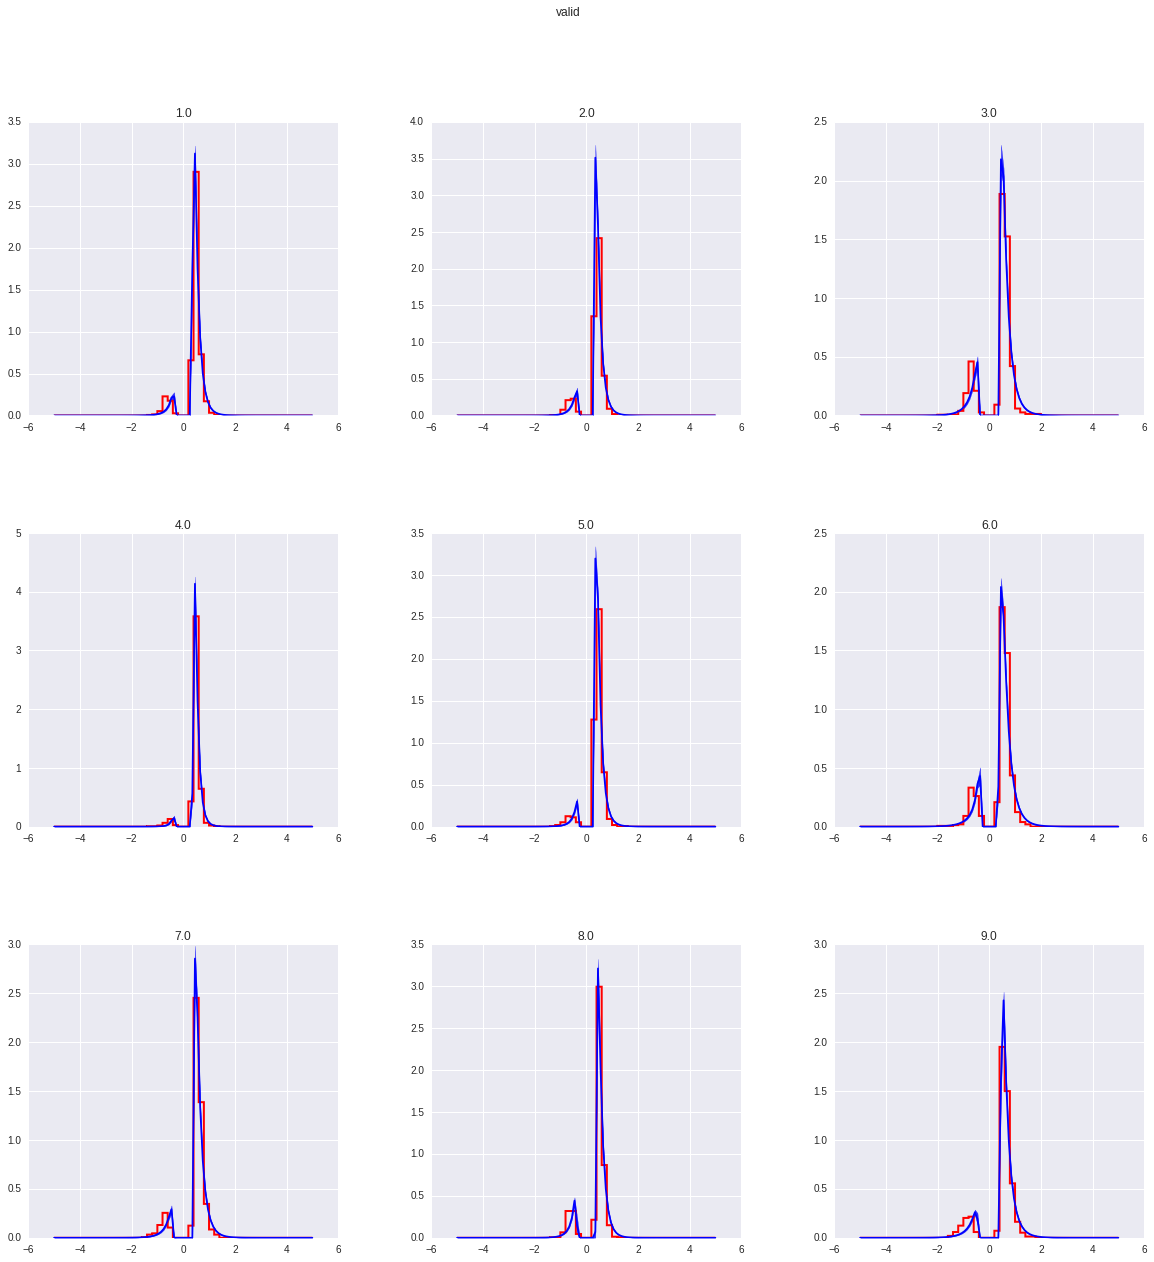

In [13]:
model.plot_posterior_predictive(figsize = (20,20), samples = 100, bins = 50)

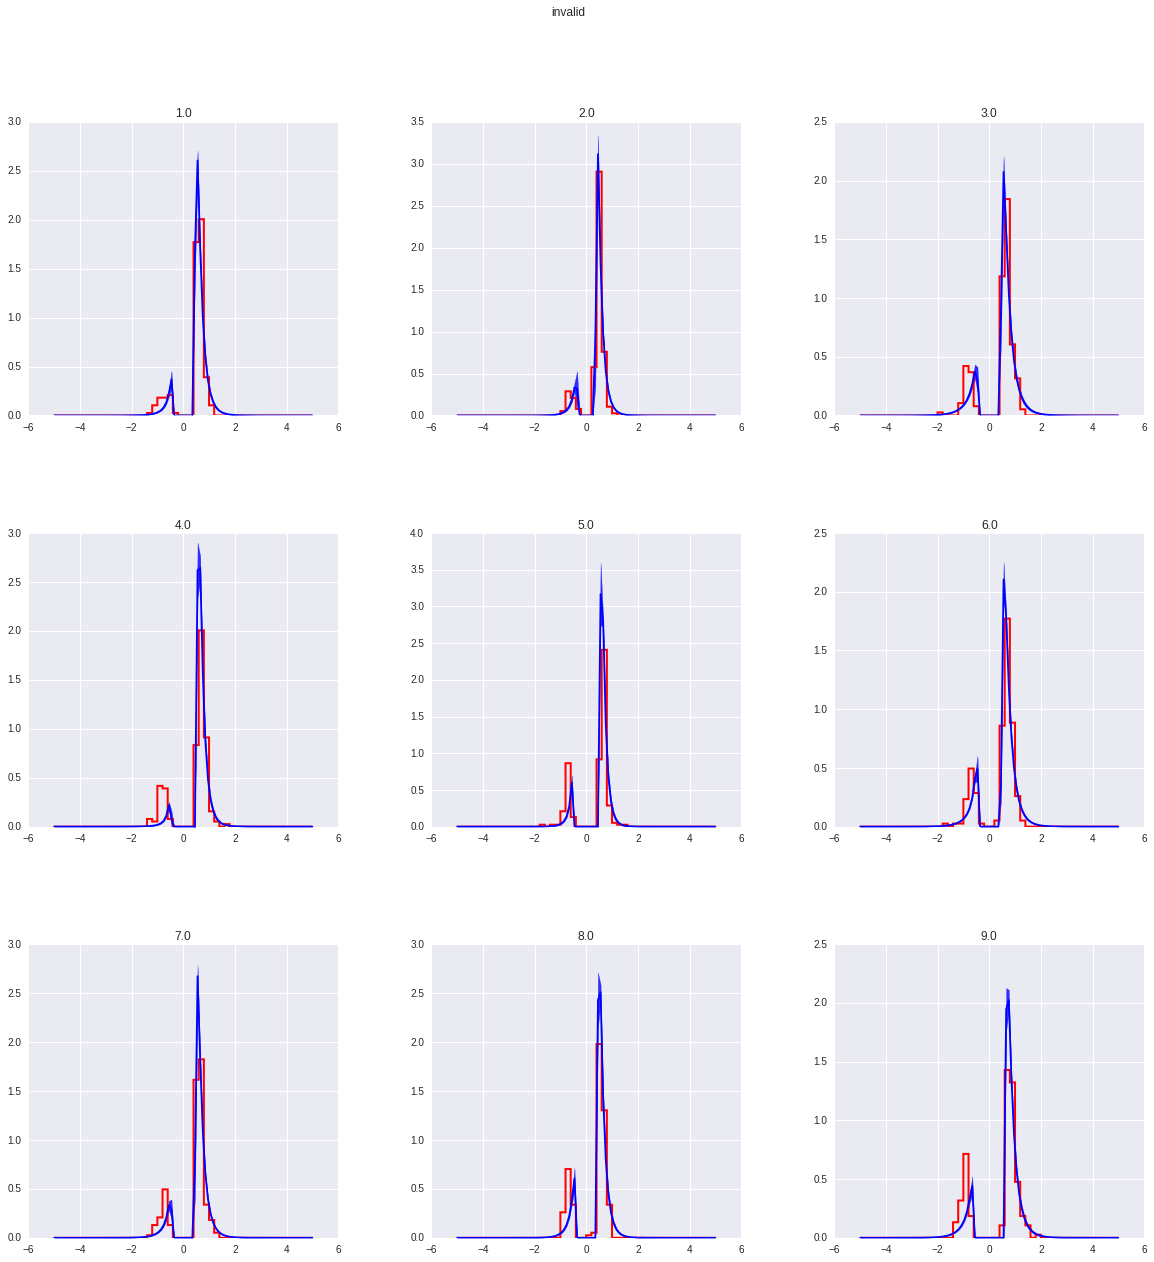

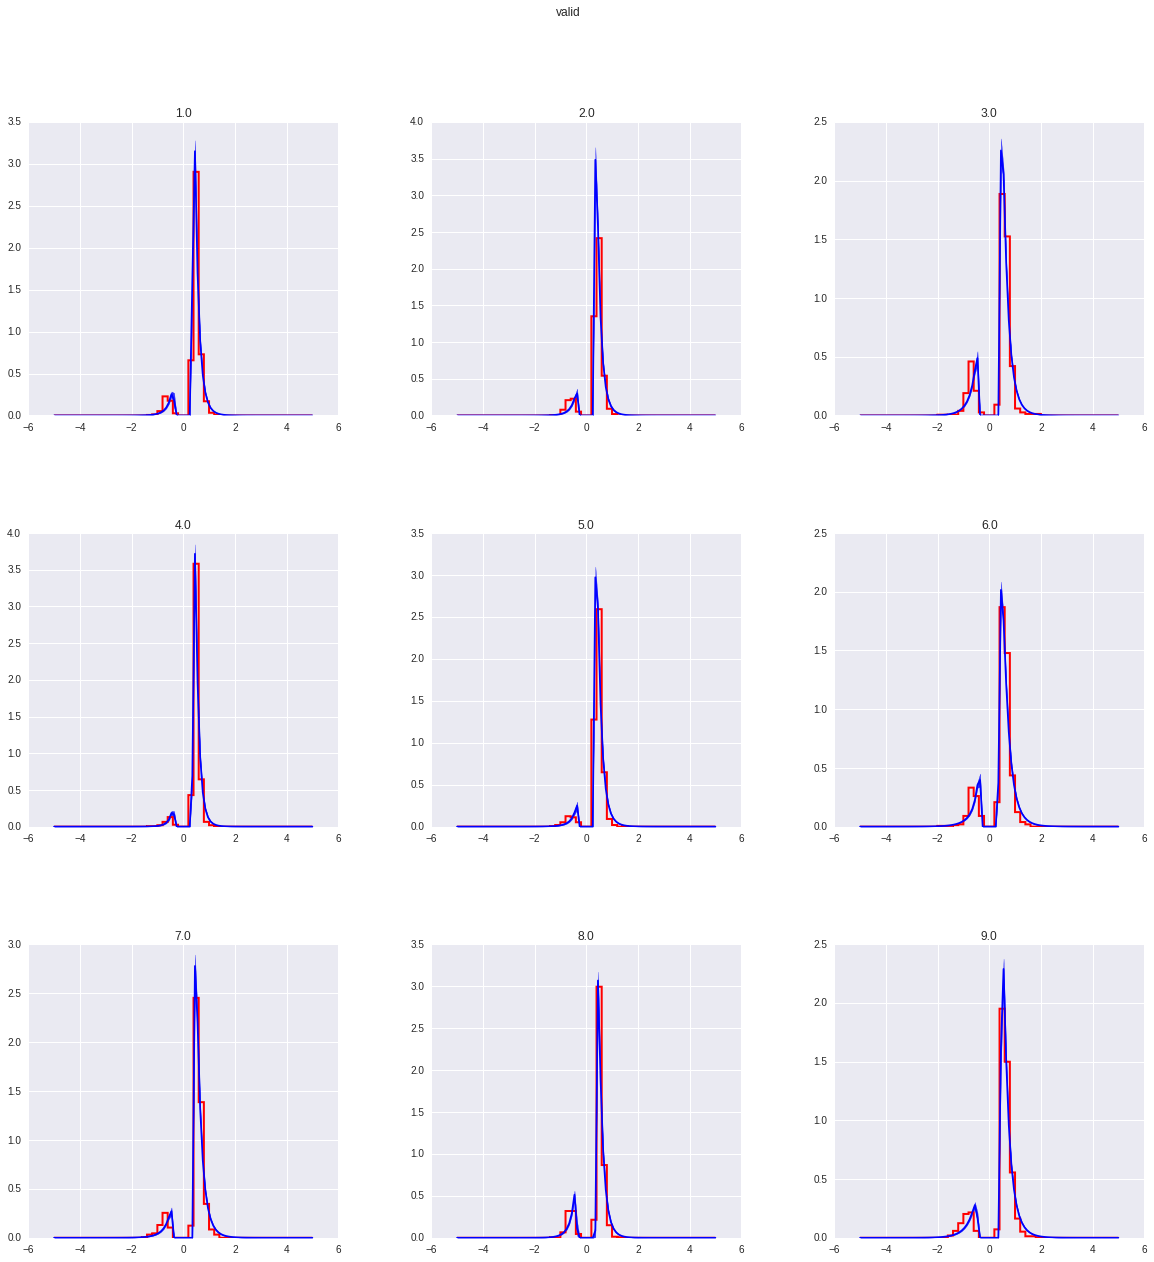

In [14]:
model_fixDR.plot_posterior_predictive(figsize=(20,20), samples = 100, bins = 50)

In [11]:
#subset model parameter statistics to single subject parameters for plotting
#indices = ['a(valid)' , 'a(invalid)' ,'a_std' , 'v(valid)' , 'v(invalid)' ,'v_std' ,
#           't(valid)' , 't(invalid)' ,'t_std' , 'z(valid)' , 'z(invalid)' ,'z_std', 'sv(valid)', 'sv(invalid)', 'st(valid)', 'st(invalid)']
indices = ['a(valid)' , 'a(invalid)' , 'a_std(valid)', 'a_std(invalid)', 'v(valid)' , 'v(invalid)',  'v_std(valid)', 'v_std(invalid)',
           't(valid)' , 't(invalid)' , 't_std(valid)', 't_std(invalid)',
           'z_std(valid)', 'z_std(invalid)','z(valid)' , 'z(invalid)' ,
           'sv(valid)', 'sv(invalid)', 'st(valid)', 'st(invalid)'] #variables to drop
stats = pd.DataFrame(stats)
plotsub_stats = stats.drop(indices); plotsub_stats = pd.DataFrame(plotsub_stats.loc[:,'mean'])
plotsub_stats['modelparam'] = np.sort(np.tile(range(1,5),18))
plotsub_stats['validity']   = np.tile([1,2],36)
plotsub_stats['subject']    = np.tile(np.sort(np.tile(range(1,10), 2)),4)

plotsub_stats.loc[plotsub_stats.modelparam ==1, 'modelparam'] = 'a'; plotsub_stats.loc[plotsub_stats.modelparam ==2, 'modelparam'] = 'v'
plotsub_stats.loc[plotsub_stats.modelparam ==3, 'modelparam'] = 't'; plotsub_stats.loc[plotsub_stats.modelparam ==4, 'modelparam'] = 'z'

plotsub_stats.loc[plotsub_stats.validity==1, 'validity'] = 'invalid';plotsub_stats.loc[plotsub_stats.validity==2, 'validity'] = 'valid'
#visualise parameter estimates by validity
plt.rcParams['figure.figsize'] = (15,10)
ax = sns.barplot(data = plotsub_stats, x = 'modelparam', hue = 'validity', y = 'mean')

ax.set_xticklabels(['decision threshold', 'drift rate', 'non-decision time', 'bias'])
ax.set_ylabel('parameter value'); ax.set_xlabel('model parameter')
#plt.savefig(os.path.join(os.getcwd(), 'modelparameter_barplot_9subs'))

ValueError: labels ['a(valid)' 'a(invalid)' 'a_std(valid)' 'a_std(invalid)' 'v_std(valid)'
 'v_std(invalid)' 't_std(valid)' 't_std(invalid)' 'z_std(valid)'
 'z_std(invalid)' 'sv(valid)' 'sv(invalid)' 'st(valid)' 'st(invalid)'] not contained in axis

Plotting a
Plotting v(invalid)
Plotting v(valid)
Plotting t(invalid)
Plotting t(valid)


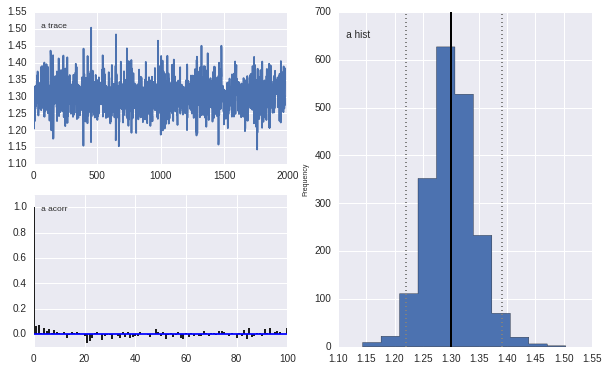

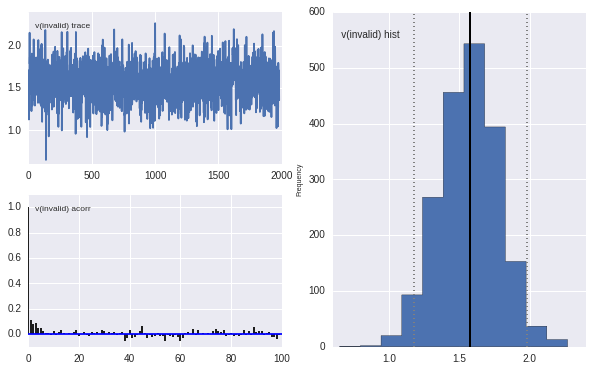

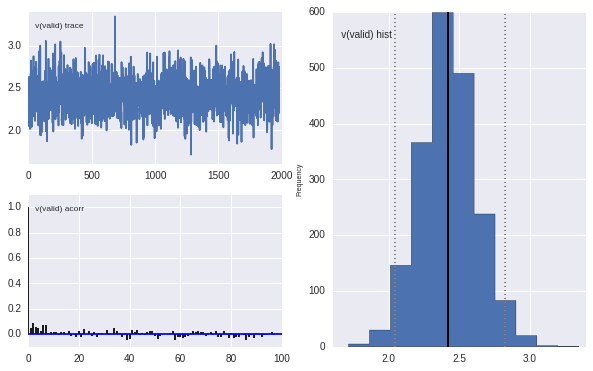

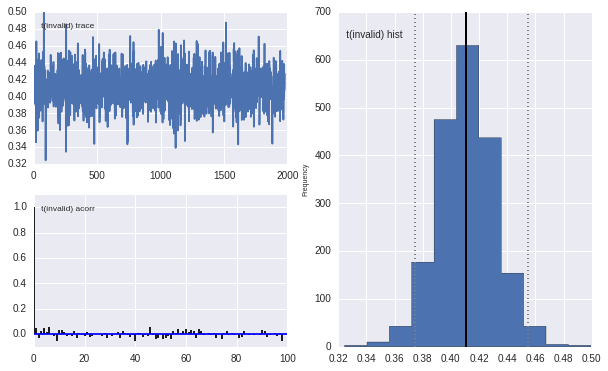

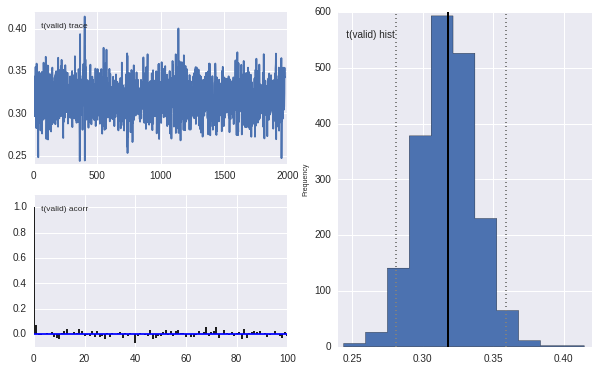

In [12]:
plt.rcParams['figure.figsize'] = (5,5)
# visually check that mcmc chains have converged
model.plot_posteriors(['a', 'v', 't'])

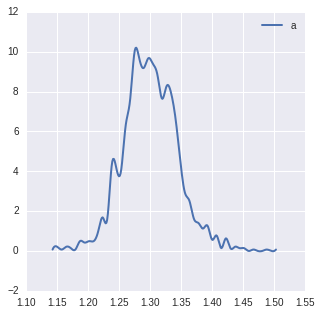

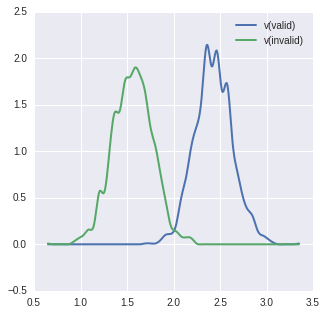

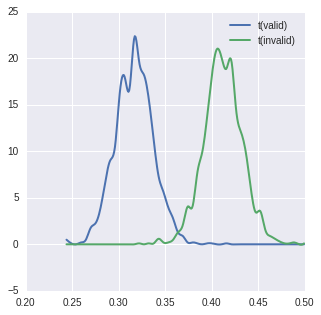

In [20]:
a, v_valid, v_invalid, t_valid, t_invalid = model.nodes_db.node[['a','v(valid)', 'v(invalid)','t(valid)', 't(invalid)']]

#plot posterior nodes for parameters by validity
hddm.analyze.plot_posterior_nodes([a]) #decision criterion
hddm.analyze.plot_posterior_nodes([v_valid, v_invalid]) #drift rate
hddm.analyze.plot_posterior_nodes([t_valid, t_invalid]) #non-decision time

In [21]:
model_nocond = hddm.HDDM(data=attention, p_outlier=0.05, bias = True, trace_subjs = True, include = {'a', 't', 'v', 'z', 'sv'})
model_nocond.find_starting_values()
model_nocond.sample(2000, burn=20, dbname = 'DDM_attention_NoValidityGrouping.db', db = 'pickle')
model_nocond.save('DDM_attention_NoValidityGrouping')

 [-----------------100%-----------------] 2000 of 2000 complete in 128.2 sec

In [ ]:
print 'full model no validity: ', model_nocond.dic_info
print 'full model: ', model.dic_info
print 'fixed drift rate model: ', model_fixDR.dic_info

In [ ]:
ppc_model_nocond = hddm.utils.post_pred_gen(model_nocond)
ppc_model_fixDR  = hddm.utils.post_pred_gen(model_fixDR)
ppc_model        = hddm.utils.post_pred_gen(model)

#template for looking at fits
#model_compare = hddm.utils.post_pred_stats(model.data, ppc_model)
#print model_compare[model_compare.index.isin(['accuracy', 'mean_ub', 'mean_lb'])] #plot accuracy estimates and upper/lower bounds

In [13]:
def permutationTest(group1, group2, nrand=10000, tail=0, paired=False):

    """
    non-parametric permutation test (Efron & Tibshirani, 1998)
    tail = 0 (test A~=B), 1 (test A>B), -1 (test A<B)
    """

    a = group1
    b = group2
    ntra = len(a)
    ntrb = len(b) 
    meana = np.mean(a)
    meanb = np.mean(b)
    triala = np.zeros(nrand)
    trialb = np.zeros(nrand)
    
    if paired:
        for i in range(nrand):
            alldat = np.vstack((a,b)).T
            for j in range(ntra):
                alldat[j,:] = alldat[j,np.argsort(np.random.rand(2))]
            triala[i] = alldat[:,0].mean()
            trialb[i] = alldat[:,1].mean()
            
    else:
        alldat = np.concatenate((a,b))
        indices = np.arange(alldat.shape[0])
        for i in range(nrand):
            random.shuffle(indices)
            triala[i] = np.mean(alldat[indices[:ntra]])
            trialb[i] = np.mean(alldat[indices[ntra:]])
            
    if tail == 0:
        p_value = sum(abs(triala-trialb)>=abs(meana-meanb)) / float(nrand)
    else:
        p_value = sum((tail*(triala-trialb))>=(tail*(meana-meanb))) / float(nrand)

    return(meana-meanb, p_value)

In [14]:
temp = stats[stats.index.isin(['(.)_subj.(.)'])]
temp = stats

In [15]:
temp

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.30164,0.0428112,1.2215,1.27442,1.30047,1.32929,1.39153,0.00119074
a_std,0.116801,0.0389994,0.0640782,0.0899552,0.109135,0.133774,0.220198,0.00145247
a_subj.1,1.27536,0.0291012,1.22086,1.25541,1.27417,1.29524,1.33537,0.00127122
a_subj.2,1.17247,0.0299206,1.11217,1.15224,1.1729,1.19456,1.22907,0.00142076
a_subj.3,1.31235,0.0298195,1.25526,1.29323,1.31144,1.33084,1.37381,0.00147706
a_subj.4,1.33828,0.0384276,1.26257,1.31317,1.33687,1.364,1.41362,0.00206991
a_subj.5,1.26393,0.0331239,1.19852,1.24183,1.26416,1.28682,1.32455,0.00168362
a_subj.6,1.44891,0.0330818,1.38861,1.42572,1.44775,1.47048,1.51752,0.00155188
a_subj.7,1.32883,0.0315633,1.27112,1.30638,1.32747,1.34971,1.39404,0.00142434
a_subj.8,1.16272,0.0292064,1.10489,1.14333,1.16233,1.18303,1.2201,0.00146636


In [65]:
params_of_interest_i  = ['a', 'v(invalid)', 't(invalid)', 'z(invalid)']
params_of_interest_v  = ['a', 'v(valid)'  , 't(valid)'  , 'z(valid)']
params_of_interest_is = ['a_subj', 'v_subj(invalid)', 't_subj(invalid)', 'z_subj(invalid)']
params_of_interest_vs = ['a_subj', 'v_subj(valid)'  , 't_subj(valid)'  , 'z_subj(valid)']

params_v = []
params_i = []
ind = np.ones(len(sublist), dtype=bool)

In [66]:
for p in range(len(params_of_interest_vs)):
    params_v.append(np.array([stats.lookup(['{}.'.format(params_of_interest_vs[p]) + str(s)], ['mean']) for s in sublist])[ind].ravel())
    params_i.append(np.array([stats.lookup(['{}.'.format(params_of_interest_is[p]) + str(s)], ['mean']) for s in sublist])[ind].ravel())


In [81]:
param_names = ['a', 'v', 't', 'z']
parameters = pd.DataFrame(np.vstack(params_v).T, columns = param_names)
parameters

,a,v,t,z
0,1.275363,2.653698,0.292540,0.447171
1,1.172471,2.389017,0.274424,0.479192
2,1.312346,1.716736,0.350617,0.455343
3,1.338282,3.758383,0.303544,0.386006
4,1.263935,2.779814,0.258697,0.424704
5,1.448907,2.024922,0.285606,0.380091
6,1.328832,2.234267,0.342209,0.460450
7,1.162718,2.319149,0.328343,0.421211
8,1.385844,1.943971,0.380668,0.481889


In [83]:
parameters['subject'] = sublist
parameters

,a,v,t,z,subject
0,1.275363,2.653698,0.292540,0.447171,1
1,1.172471,2.389017,0.274424,0.479192,2
2,1.312346,1.716736,0.350617,0.455343,3
3,1.338282,3.758383,0.303544,0.386006,4
4,1.263935,2.779814,0.258697,0.424704,5
5,1.448907,2.024922,0.285606,0.380091,6
6,1.328832,2.234267,0.342209,0.460450,7
7,1.162718,2.319149,0.328343,0.421211,8
8,1.385844,1.943971,0.380668,0.481889,9


In [ ]:
# comparison of hierarchical models is done using DIC (deviance information criterion) -- lower DIC indicates better fit
# compare models where all parameters are estimated